In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from context import *

np.random.seed(42)

# Missing Values

The large majority of datasets have missing values.
Whatever the domain, there is always a mechanical defect which will prevent measurement.
There is always a participant that do not want to fill a particular field in a form.
And, there is always a simple phenomenon that do not require as much data to be described.
Anyway, analysts must be able to identify those missing values and treat them properly.

## Definition

Literature about missing values agrees on 3 types of missingness.

**MCAR**

Values missing completely at random deal with missingness which have absolutely no relation with the data themselves.
For example, a machine may stop taking data during a power outage.
Nothing in the rest of the data could give us a hint about why those data are missing.
The following code simulates such a missingness.

In [ ]:
data = np.random.randn(5, 5)
data

array([[ 0.49671415, -0.1382643 ,  0.64768854,  1.52302986, -0.23415337],
       [-0.23413696,  1.57921282,  0.76743473, -0.46947439,  0.54256004],
       [-0.46341769, -0.46572975,  0.24196227, -1.91328024, -1.72491783],
       [-0.56228753, -1.01283112,  0.31424733, -0.90802408, -1.4123037 ],
       [ 1.46564877, -0.2257763 ,  0.0675282 , -1.42474819, -0.54438272]])

Here we define where values will be missing by a random process, independent of the `data` object.

In [ ]:
missing = np.random.binomial(n=1, p=0.4, size=(5, 5))
missing

array([[1, 0, 0, 1, 1],
       [1, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [1, 1, 1, 1, 0]])

The final dataset then look like the following.

In [ ]:
np.where(missing == 1, np.nan, data)

array([[        nan, -0.1382643 ,  0.64768854,         nan,         nan],
       [        nan,  1.57921282,  0.76743473,         nan,  0.54256004],
       [-0.46341769, -0.46572975,  0.24196227,         nan, -1.72491783],
       [        nan, -1.01283112,  0.31424733, -0.90802408, -1.4123037 ],
       [        nan,         nan,         nan,         nan, -0.54438272]])

**MAR**

Values missing at random describe missingness due to the context of the data measurement.
The missingness is however not related to the value that would have taken the missing variable.
For example, an electric thermometer may not work in a humid environment, whatever the actual temperature.
If we measure the humidity, we can actually estimate when there will be missing data.
However, we can not predict what the temperature would have been if it were measured.
This can be simulated with the following code.

Here there are two processes that contribute.
First, values can be missing only if the first column has a negative value.
Then, among all the values in the three middle columns, an independent random process decides which values will be missing.

In [ ]:
missing2 = np.zeros(missing.shape)
missing2[:, 1:] = (data[:, 0] < 0).reshape(-1, 1) & (missing[:, 1:] == 1)

In [ ]:
np.where(missing2 == 1, np.nan, data)

array([[ 0.49671415, -0.1382643 ,  0.64768854,  1.52302986, -0.23415337],
       [-0.23413696,  1.57921282,  0.76743473,         nan,  0.54256004],
       [-0.46341769, -0.46572975,  0.24196227,         nan, -1.72491783],
       [-0.56228753, -1.01283112,  0.31424733, -0.90802408, -1.4123037 ],
       [ 1.46564877, -0.2257763 ,  0.0675282 , -1.42474819, -0.54438272]])

**NMR**

Data not missing at random refer to data missing specifically because of the value they should have been.
In the case of a survey concerning drug use, a non consumer would not bother answer 'no' to a question about drug consumption.
However, a consumer may choose not to fill the form, knowing that the consumption is technically illegal.
Then, there would be a high chance that the missing values are actual 'yes'.

In the example below, missing values all correspond to the initial negative values.
Contrary to the drug consumption example, it is not straighforward to understand the actual missing value.
We know those values are negative but we don't know how much.

In [ ]:
np.where(data < 0, np.nan, data)

array([[0.49671415,        nan, 0.64768854, 1.52302986,        nan],
       [       nan, 1.57921282, 0.76743473,        nan, 0.54256004],
       [       nan,        nan, 0.24196227,        nan,        nan],
       [       nan,        nan, 0.31424733,        nan,        nan],
       [1.46564877,        nan, 0.0675282 ,        nan,        nan]])

Knowing the kind of missingness we are dealing with often requires expert knowledge of the domain and/or the data gathering procedure.
However, having a decent knowledge of the missingness greatly help in choosing the correct strategy in order to manage the situation.

# Evaluating missing data

Identifying missing data is a central theme at the beginning of an analysis.
Missing data, and particularly their type of missingness, force the analyst to ask questions about how the data was gathered.
This is a source of knowledge about the dataset.
The analyst may further the knowledge by understanding how missingness is correlated.

For this analysis, we will study a particular dataset concerning patients in an hospital.
The dataset can be downloaded and preprocessed with the following pipeline.
For security reasons, we have no specific information about either the patients or the meaning of the features. 
Everything is anonymized.

`python -m src.data.patient`


In [ ]:
df = pd.read_parquet(INTDIR / "patients.parquet")
df.shape

(13533, 43)

The first thing we can estimate is how much missing values each column contains.
We can either perform a simple estimate, or use the ```missingno``` library which helps us with nice visualisations.


In [ ]:
df.isnull().mean().sort_values(ascending=False)

feat_22     1.000000
feat_23     1.000000
feat_2      1.000000
feat_3      1.000000
feat_6      1.000000
feat_7      1.000000
feat_8      1.000000
feat_25     1.000000
feat_33     0.999852
feat_4      0.999778
feat_10     0.999261
feat_20     0.989581
feat_37     0.973768
feat_30     0.963940
feat_36     0.954925
feat_39     0.951895
feat_28     0.950491
feat_18     0.940072
feat_35     0.918348
feat_32     0.918348
feat_29     0.915540
feat_12     0.910885
feat_1      0.896919
feat_19     0.894628
feat_21     0.893520
feat_13     0.871647
feat_9      0.861006
feat_15     0.824060
feat_17     0.824060
feat_0      0.824060
feat_38     0.741669
feat_31     0.435159
feat_14     0.333186
feat_27     0.317372
feat_34     0.070864
feat_5      0.060667
feat_16     0.060667
feat_26     0.060667
feat_24     0.060667
feat_11     0.000000
visit_id    0.000000
sex         0.000000
age         0.000000
dtype: float64

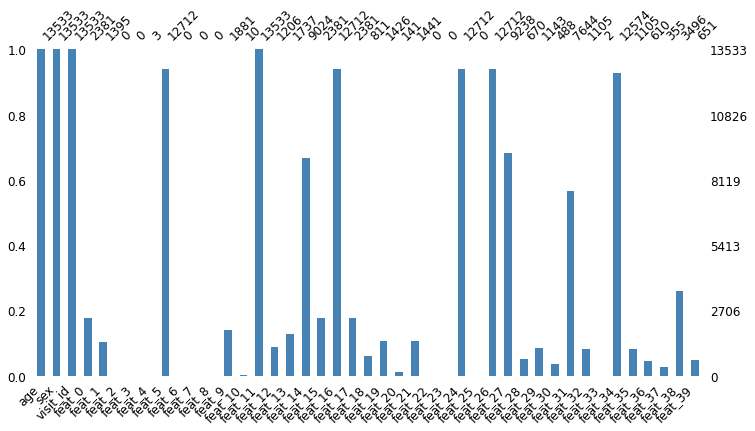

In [ ]:
# draw a completeness plot per columns
import missingno as msno

msno.bar(df, figsize=(12, 6), fontsize=12, color="steelblue");

For this particular dataset, from real world data, we have a very heterogeneous situation.
At the very bottom, we have four variables which have no missing values.
We also have many variables which are almost completely empty.
The notion of missingness is very central in the analysis of this dataset.

Another point of interest is the 8 columns that are completely missing.
This tells us that this dataset was most probably a partial selection of a larger database.
It must just have happened that those columns are rarely filled and that for this specific selection no value was filled.

`missingno` proposes another useful visualisation : the correlation between missingnesès.
The library create a dummy variable for each column of the dataset.
This dummy variables is filled with 1 if the variable is present and to 0 is the variable is absent.
Then, the library computes the correlation between those variables.
A high value means that some features are always missing together.
A very negative value means that one feature is always present when the other is present.

In this example, we observe that the features 0, 15 and 17 are always missing together.
Similarly, features 16, 24, 26, 5 and 34 are almost always missing together.
Then we can understand that those groups of variables are linked in some ways.
More expert knowledge may be required to better understand this meaning.

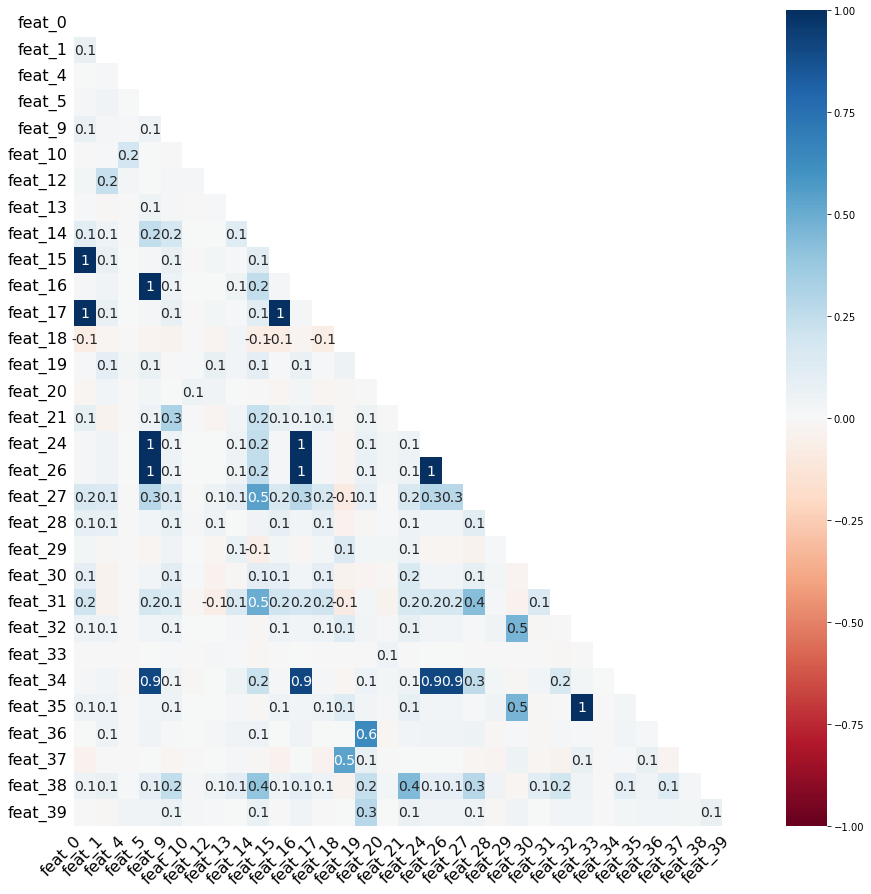

In [ ]:
msno.heatmap(df, figsize=(15, 15));

## Managing missing data

Missing data reduce the quantity and quality of data.
In practice, they prevent analysts from using most of data science algorithms, which require a completely filled dataset.
It is then necessary to find a way to fill those missing spaces by numbers.
Many techniques have been proposed and tested on benchmarks.
Their effectiveness depends on the benchmark and on the type of missingness at hand.
The set of techniques range from very simple to very complex.
The following paragraphs propose a description of the most popular techniques.

### Suppression

The first idea that may come to mind to deal with missing values is to remove all missing data.
In the case of tabular data, this would mean to remove all instances or columns containing missing values.
In the case at stake, removing columns with missing values would leave only 3 columns : age, sex and feat_11.
Then we understand how this strategy may be dangerous in term of available data for analysis.
Furthermore, when data are not missing completely at random, removing instances may bias the data.
In the case of the form about drug use, only drug consummers would be removed, which would definitely change the study.

### Simple Imputation

Instead of reducing the quantity of data, we can replace the missing values by arbitrary numbers.
This strategy biases in some way the dataset because we impute **false** values.
Filling values should be chosen with care depending on how the data will be used later.
For instance, in the case of a classification, the filling values will not interact the same way with a logistic regression and with a random forest.
The following lists a couple a strategies to choose an arbitrary filling value.

**Expert knowledge**

A good first step is to evaluate if the missing data tells us something about the phenomenon at stake.
In case of MNR or even MAR, expert knowledge may help us define a decent proxy for the missing variable.
If a data is missing because of a detector saturation, it is sensible to choose the saturation value to fill this data.
It is not perfect, but it may be close enough to have valid results later on.

**Median, mean, mode**

The second option to fill missing values is to use the available statistics of the variable to find a decent value.
The mean is the most common choice for continuous variables.
The mode may be used for categorical data.
This solution has a tendency to break the correlation with the rest of the variables.
There is then a risk of obtaining aberrant results.
This [article](https://towardsdatascience.com/why-using-a-mean-for-missing-data-is-a-bad-idea-alternative-imputation-algorithms-837c731c1008), which deals with this issue, proposes a case where an 80 years old women is attributed a young person physical condition when giving her the mean value of the dataset.

**Adding a variable**

The previous solutions have little chance of taking into account the correlations between missing and non missing data.
In the case of MAR, and even more with NMR, the context can not be neglected.
Depending on the situation, it may be informative to add a new variable which states where missing data used to be.
With this strategy, we keep the information that there was something missing.
This particular technique is proposed in the [fastai course](https://www.youtube.com/watch?v=CzdWqFTmn0Y&list=PLfYUBJiXbdtSyktd8A_x0JNd6lxDcZE96), for any type of classification models.

### Multivariate imputations

The previous techniques are simple but do not necessarily take into account the correlations between variables.
This section presents more advanced solutions which rely on the interactions between all variables to 'predict' what missing values should have been.

**KNN**

The most simple technique uses a KNN algorithm.
For a point with a missing value, the algorithm searches for its closest neighbours with a modified notion of distance accepting missing values.
The missing value is then filled by the weighted average of this variable over all selected neighbours.
In some way, this technique is an improvement of mean encoding, by not taking the mean over the entire dataset but instead on a more local region.
This requires to have a notion of distances between instances. 
See the course on dimension reduction and and category encoding for further discussions on the notion of distance.

In [ ]:
columns = ["age", "feat_5", "feat_9", "feat_11"]

In [ ]:
df[columns].head(10)

age    feat_5    feat_9   feat_11
0   87 -2.265400       NaN -0.208635
1   76 -0.222855       NaN -0.420816
2   57  1.109240  0.970227  1.495582
3    6  1.642081       NaN -0.381453
4   63  1.730885       NaN  0.189952
5   68 -0.311660       NaN -0.305246
6   63  0.043563       NaN -0.445268
7   56  1.286854       NaN -0.336472
8   65  0.931627       NaN  0.101560
9   68 -0.222855  0.001172  0.025560

In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)
knn_out = pd.DataFrame(imputer.fit_transform(df[columns]), columns=columns)
knn_out.head(10)

age    feat_5    feat_9   feat_11
0  87.0 -2.265400 -0.725619 -0.208635
1  76.0 -0.222855  0.037511 -0.420816
2  57.0  1.109240  0.970227  1.495582
3   6.0  1.642081 -0.701393 -0.381453
4  63.0  1.730885  0.703737  0.189952
5  68.0 -0.311660  0.824868 -0.305246
6  63.0  0.043563  0.921774 -0.445268
7  56.0  1.286854  1.030793 -0.336472
8  65.0  0.931627  1.139811  0.101560
9  68.0 -0.222855  0.001172  0.025560

**MICE**

MICE is an iterative method which proposes to fill missing values by predicting them from the other variables.
The first step consists in filling the missing values with a simple method, usually a mean encoding.
Then, it trains an algorithm to predict a single variable from the remaining ones.
The missing values of this column are then replaced by their prediction.
Then these predictions will be used to predict the values of another column.
Applying multiple times this strategy over all variables with missing values should allow to converge to decent and specialised filling values.


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp_mean = IterativeImputer(random_state=0)
mice_out = pd.DataFrame(imp_mean.fit_transform(df[columns]), columns=columns)
mice_out.head(10)

age    feat_5    feat_9   feat_11
0  87.0 -2.265400 -0.781615 -0.208635
1  76.0 -0.222855 -0.051765 -0.420816
2  57.0  1.109240  0.970227  1.495582
3   6.0  1.642081  0.705691 -0.381453
4  63.0  1.730885  0.523161  0.189952
5  68.0 -0.311660 -0.082205 -0.305246
6  63.0  0.043563  0.067590 -0.445268
7  56.0  1.286854  0.474927 -0.336472
8  65.0  0.931627  0.269546  0.101560
9  68.0 -0.222855  0.001172  0.025560

When looking closely at the results, we see that the two methods give significantly different results.
Because they use radically different hypotheses, they may reach very different predictions.
The study of those difference may be an axis of analysis to better understand the dataset.

In [ ]:
(knn_out - mice_out).abs()["feat_9"]

0        0.055996
1        0.089276
2        0.000000
3        1.407083
4        0.180576
           ...   
13528    0.114115
13529    0.524579
13530    0.618789
13531    1.847079
13532    1.076272
Name: feat_9, Length: 13533, dtype: float64

**Multiple imputation**

This technique is an adaptation of oversampling.
The first step is to evaluate the distribution of a variable, when values are available.
Then, each time that this variable is missing for an instance, copies of this instance are integrated in the dataset, with the missing value filled with random values drawn on the distributions.


### Conclusion

Missing values are present in most datasets.
There are different types of missing values which have variable impacts and correlations with the rest of the dataset.
Because most of the data science algorithms require no missing value, imputing strategies are almost always required.
Those strategies can be quite simple, like filling with a single value, or using algorithms to evaluate the missing values depending on their context.

Whatever the strategy, it must always be used in coordination with the ultimate goal of the analysis.
Depending on how missing values are filled, algorithms down the road may have divergent behaviour.
Filling missing values is not an automatic procedure but must be thought in the context of the analysis.

# Exercice

## Impact of imputation

- Generate two 2D datasets : on with uncorrelated variables, and one correlated variables.

- For each previous dataset, create three additionnal datasets by removing values according to each type of missingness.

- Compare and comment the difference of data distribution without and with missing values.

- Apply various imputation techniques and compare the results with the initial data distribution.